# Retirement scenarios

I’m working on figuring out retirement scenarios. I wasn’t satisfied with the usual online calculators. I made a spreadsheet, but it was hard to see how the different variables affected the outcome. Aha! This sounds like a good use for a Jupyter Notebook!

This notebook has a simulation of money flows over years, with variables and sliders for things like when to sell the empty-nest house, for how much, and so on.  Instead of just plotting one outcome, it has a way to make the relationship between the variables and the outcome more apparent: you can choose one of the variables, and plot its multiple values on a single graph. And of course, I took it one step further, so that I could declare my parameters, and have the widgets, including the selection of the variable to auto-slide, generated automatically.

I wrote about it on my blog [here](https://nedbatchelder.com/blog/201610/multiparameter_jupyter_notebook_interaction.html) and more recently [here](https://nedbatchelder.com/blog/202402/updated_multiparameter_interactive_jupyter_notebook.html).

# Parameter and Model classes

The general notion of a declarative multi-parameter model with an auto-slider is contained in a class:

In [1]:
# Requirements:
#   ipywidgets
#   ipympl
#   jupyter
#   jupyterlab
#   matplotlib

%matplotlib widget
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

from dataclasses import dataclass

from ipywidgets import fixed, interact, IntSlider, FloatSlider

@dataclass
class Param:
    """
    A parameter for `Model`.
    """
    default: float
    range: tuple[float, float, float]

    def _is_float(self):
        """Despite the float declaration, are we float or int?"""
        is_float = isinstance(self.default, float)
        is_float = is_float or any(isinstance(v, float) for v in self.range)
        return is_float
        
    def make_widget(self):
        """Create a widget for a parameter."""
        wtype = FloatSlider if self._is_float() else IntSlider
        return wtype(
            value=self.default,
            min=self.range[0], max=self.range[1], step=self.range[2], 
            continuous_update=True,
        )

    def format(self, value):
        if self._is_float():
            return f"{value:.2f}"
        else:
            return f"{int(value):,d}"
            

class Model:
    """
    A multi-parameter model.
    """

    output_limit = None
    num_auto = 7
    
    def _calc_auto_values(self, auto_param):
        rng = list(auto_param.range)
        rng[1] += rng[2]
        
        auto_values = np.arange(*rng)
        if len(auto_values) > self.num_auto:
            lo, hi = rng[:2]
            step = (hi-lo)/self.num_auto
            auto_values = np.arange(lo, hi+step, step)
        return auto_values
    
    def _show_it(self, auto_param_name, **kw):
        auto_param = self.params[auto_param_name]
        auto_values = self._calc_auto_values(auto_param)
        
        self.ax.clear()
        if self.output_limit is not None:
            self.ax.set_ylim(*self.output_limit)
        
        self.tweak_axes(self.ax)
        lines = []
        labels = []
        
        for auto_val in auto_values:
            kw[auto_param_name] = auto_val
            ys = self.run(self.inputs, **kw)
            lines += self.ax.plot(self.inputs, ys, label=str(auto_val))
            labels.append(auto_param.format(auto_val))
            
        self.ax.legend(lines, labels)
        self.fig.canvas.toolbar_visible = False
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False
        self.fig.canvas.draw()

    def tweak_axes(self, ax):
        pass
    
    def draw(self):
        self.fig, self.ax = plt.subplots(layout="constrained")
        self._show_it(auto_param_name=min(self.params), **{name:p.default for name, p in self.params.items()})
        
    def interact(self):
        self.fig, self.ax = plt.subplots(figsize=(8, 4), layout="constrained")
        widgets = {name:p.make_widget() for name, p in self.params.items()}
        param_names = sorted(self.params)
        interact(self._show_it, auto_param_name=param_names, **widgets)

# Defining the model

To make a model, derive a class from Model. Define a dict called params as a class attribute. Each parameter has a default value, and a range of values it can take, expressed as (min, max, step):

In [2]:
class Retirement(Model):
    params = dict(
        invest_return=Param(4.0, (1.0, 6.0, 0.5)),
        p401k=Param(17, (10, 25, 1)),
        retire_age=Param(65, (60, 75, 1)),
        live_on=Param(100000, (90000, 150000, 10000)),
        inflation=Param(2.0, (1.0, 4.0, 0.25)),
        sell=Param(750_000, (500_000, 1_000_000, 100_000)),
        buy=Param(500_000, (300_000, 1_200_000, 100_000)),
    )

    # Your class can also have some constants:
    start_savings = 500_000
    salary = 100_000
    socsec = 14000
    mortgage_principal = 200_000

    # Define the inputs to the graph (the x values), and the range of the output (the y values):
    output_limit = (0, 3_000_000)
    inputs = np.arange(50, 101)
    
    num_auto = 5
    
    def tweak_axes(self, ax):
        ax.minorticks_on()
        ax.get_yaxis().set_major_formatter(
            tkr.FuncFormatter(lambda x, p: "${:.1f}M".format(x/1000000))
        )

    # Finally, define a run method that calculates the output from the inputs.
    # It takes the inputs as an argument, and also has a keyword argument for
    # each parameter you defined:
    
    def run(
            self, 
            inputs, 
            invest_return,
            p401k, 
            retire_age, 
            live_on,
            inflation, 
            sell, 
            buy, 
        ):
        for year, age in enumerate(inputs):
            if year == 0:
                money = self.start_savings
            else:
                money = yearly_money[-1]
 
            if year == 0:
                yearly_money = [money]
                continue

            money = money*(1+(invest_return/100))
            if age <= retire_age:
                # Working
                money += max(self.salary * (p401k/100), 20_000)
                if age == retire_age:
                    money += sell*.95 - self.mortgage_principal - buy
            else:
                # Retirement
                money += self.socsec
                money -= live_on * (1 + inflation/100)**year
            yearly_money.append(money)

        ret = np.array(yearly_money)
        return ret

# Running the model

To run the model, instantiate it and call interact().  You can choose an "auto_param" at the top.  Its values will determine the lines on the plot.  The other sliders can be adjusted manually.

interactive(children=(Dropdown(description='auto_param_name', options=('buy', 'inflation', 'invest_return', 'l…

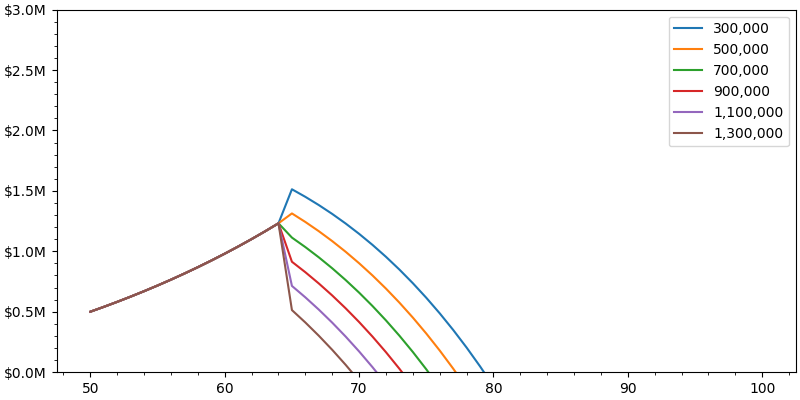

In [3]:
Retirement().interact()

# Closing thoughts

There are things I would like to be nicer about this:

- The sliders are a mess: if you make too many parameters, the slider and the graph don’t fit on the screen.
- The values chosen for the auto parameter are not “nice”, like tick marks on a graph are nice.
- It’d be cool to be able to auto-slide two parameters at once.
- The code isn’t packaged in a way people can easily re-use.